In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_path = "/content/gdrive/My Drive/Data" 
model_path = "/content/gdrive/My Drive/Models"

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

In [ ]:
data = pd.read_csv(data_path + "/ner_dataset.csv", encoding="latin1").fillna(method="ffill")

In [ ]:
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [ ]:
class SentGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(), s["POS"].values.tolist(), s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sents = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence:", self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentGetter(data)

In [ ]:
sents = [[col[0] for col in sent] for sent in getter.sents]
labels = [[col[2] for col in sent] for sent in getter.sents]

In [ ]:
print(sents[0])
print(labels[0])

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [ ]:
# transformation
def elim_tags(labels, elim_list):
  return [[l if l not in elim_list else 'O' for l in label] for label in labels]

In [ ]:
labels = elim_tags(labels, ['B-art', 'I-art', 'B-eve', 'I-eve', 'B-org', 'I-org'])

In [ ]:
tag_values = list(set([l for label in labels for l in label]))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [ ]:
tag2idx

{'B-geo': 8,
 'B-gpe': 10,
 'B-nat': 7,
 'B-per': 0,
 'B-tim': 3,
 'I-geo': 2,
 'I-gpe': 1,
 'I-nat': 4,
 'I-per': 6,
 'I-tim': 9,
 'O': 5,
 'PAD': 11}

In [ ]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [ ]:
# all tags by default

{'B-art': 8,
 'B-eve': 9,
 'B-geo': 10,
 'B-gpe': 16,
 'B-nat': 7,
 'B-org': 12,
 'B-per': 0,
 'B-tim': 3,
 'I-art': 15,
 'I-eve': 14,
 'I-geo': 2,
 'I-gpe': 1,
 'I-nat': 4,
 'I-org': 11,
 'I-per': 6,
 'I-tim': 13,
 'O': 5,
 'PAD': 17}

In [ ]:
pip install transformers

     |████████████████████████████████| 1.3MB 23.8MB/s 
     |████████████████████████████████| 2.9MB 42.4MB/s 
     |████████████████████████████████| 1.1MB 50.8MB/s 
     |████████████████████████████████| 890kB 42.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=1f4a5e5a0fc891ad865bd06c0841e25d8329d3e99a38de12d29b31b36ce8dbd2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
MAX_LEN = 75
batch_size = 32

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [ ]:
def tokenize(sent, label):
    s_tokens = []
    l_tokens = []

    for cur_w, cur_l in zip(sent, label):
        w_tokens = tokenizer.tokenize(cur_w)
        s_tokens.extend(w_tokens)
        l_tokens.extend([cur_l] * len(w_tokens))

    return s_tokens, l_tokens

In [ ]:
tokenized_data = [tokenize(sent, label) for sent, label in zip(sents, labels)]

In [ ]:
s_tokens = [slpair[0] for slpair in tokenized_data]
l_tokens = [slpair[1] for slpair in tokenized_data]

In [ ]:
inp_ids = pad_sequences([tokenizer.convert_tokens_to_ids(s_token) for s_token in s_tokens], maxlen=MAX_LEN, dtype='long', value=0.0, truncating='post', padding='post')
out_ids = pad_sequences([[tag2idx.get(l) for l in l_token] for l_token in l_tokens], maxlen=MAX_LEN, dtype='long', value=tag2idx['PAD'], truncating='post', padding='post')

In [ ]:
att_masks = [[float(idx != 0.0) for idx in ids] for ids in inp_ids]

In [ ]:
train_inp, val_inp, train_out, val_out = train_test_split(inp_ids, out_ids, random_state=0, test_size=0.1)
train_masks, val_masks, _, _ = train_test_split(att_masks, inp_ids, random_state=0, test_size=0.1)

In [ ]:
train_inp = torch.tensor(train_inp)
val_inp = torch.tensor(val_inp)
train_out = torch.tensor(train_out)
val_out = torch.tensor(val_out)
train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
train_data = TensorDataset(train_inp, train_masks, train_out)
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inp, val_masks, val_out)
val_sampler = RandomSampler(val_data)
val_loader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

In [ ]:
model = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(tag2idx), output_attentions=False, output_hidden_states=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
def get_params(isFull):
  if isFull:
    params = [{'params': [p for n, p in list(model.named_parameters())], 'weight_decay_rate': 0.01}]
  else:
    params = [{'params': [p for n, p in list(model.classifier.named_parameters())]}]
  return params

In [ ]:
pip install seqeval

     |████████████████████████████████| 51kB 6.9MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=44992a480b06385d321fe52b29ac29e5b5a03768653aeea8f9598956fe9d7bce
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
from seqeval.metrics import f1_score, accuracy_score

In [ ]:
from transformers import get_linear_schedule_with_warmup

In [ ]:
optimizer = AdamW(get_params(False), lr=3e-5, eps=1e-8)

In [ ]:
epochs = 4
max_norm = 1.0

In [ ]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)

In [ ]:
def train(model, optimizer, epochs, max_norm, name):
  train_losses, val_losses = [], []
  best = float('inf')

  for _ in trange(epochs, desc="Epoch"):
    # Training
    model.train()
    train_loss = 0

    for batch in train_loader:
      batch = tuple(b.to(device) for b in batch)
      b_inp_ids, b_masks, b_out_ids = batch
      
      model.zero_grad()
      
      loss = model(b_inp_ids, token_type_ids=None, attention_mask=b_masks, labels=b_out_ids)[0]
      loss.backward()
      
      train_loss += loss.item()
      
      torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_norm)
      
      optimizer.step()
      scheduler.step()

    train_loss /= len(train_loader)
    print("Train loss:", train_loss)

    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss, val_acc = 0, 0
    preds, outs = [], []
    for batch in val_loader:
      batch = tuple(b.to(device) for b in batch)
      b_inp_ids, b_masks, b_out_ids = batch

      with torch.no_grad():
          result = model(b_inp_ids, token_type_ids=None, attention_mask=b_masks, labels=b_out_ids)
      loss = result[0]
      logits = result[1].detach().cpu().numpy()
      b_out_ids = b_out_ids.cpu().numpy()

      val_loss += loss.item()
      preds.extend([list(p) for p in np.argmax(logits, axis=2)])
      outs.extend(b_out_ids)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print("Val loss:", val_loss)
    
    if val_loss < best:
      best = val_loss
      torch.save(model.state_dict(), model_path + "/NER" + name + ".pt")

    pred_tags = [[tag_values[p_i] for p_i, o_i in zip(p, o) if tag_values[o_i] != "PAD"] for p, o in zip(preds, outs)]
    out_tags = [[tag_values[o_i] for o_i in o if tag_values[o_i] != "PAD"] for o in outs]
    print("Val Accuracy:", accuracy_score(pred_tags, out_tags))
    print("Val F1-Score:", f1_score(pred_tags, out_tags))
    print()
  
  return train_losses, val_losses

In [ ]:
# 3e5_full_5tags (epochs 0 - 3)

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.14390641512740002
Val loss: 0.10101828801135222
Val Accuracy: 0.9661310792763349


Epoch:  25%|██▌       | 1/4 [10:19<30:58, 619.47s/it]

Val F1-Score: 0.8474653676358654

Train loss: 0.08258583054106663
Val loss: 0.09546262636780739
Val Accuracy: 0.9677901006196444


Epoch:  50%|█████     | 2/4 [20:42<20:40, 620.45s/it]

Val F1-Score: 0.8550489214612217

Train loss: 0.059781067073345184
Val loss: 0.10153220331917207
Val Accuracy: 0.9694242366428044


Epoch:  75%|███████▌  | 3/4 [31:03<10:20, 620.56s/it]

Val F1-Score: 0.8636918382913807

Train loss: 0.04445840759179365
Val loss: 0.10972487047314644
Val Accuracy: 0.9693495806823554


Epoch: 100%|██████████| 4/4 [41:24<00:00, 621.14s/it]

Val F1-Score: 0.8632939466941991



In [ ]:
train_losses, val_losses = train(model, optimizer, epochs, max_norm, '3e5_5tags')

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 1.0267201458152972
Val loss: 0.5553157057364781
Val Accuracy: 0.8490622381856943


Epoch:  25%|██▌       | 1/4 [09:48<29:24, 588.05s/it]

Val F1-Score: 0.0050977060322854725

Train loss: 0.49612486550240625
Val loss: 0.4326407462358475
Val Accuracy: 0.86216850679784


Epoch:  50%|█████     | 2/4 [19:34<19:35, 587.55s/it]

Val F1-Score: 0.14090224579322988

Train loss: 0.4275908034717356
Val loss: 0.3926238755385081
Val Accuracy: 0.8730931623435335


Epoch:  75%|███████▌  | 3/4 [29:22<09:47, 587.69s/it]

Val F1-Score: 0.23615143077196515

Train loss: 0.404565294233846
Val loss: 0.38174648662408195
Val Accuracy: 0.876900616326429


Epoch: 100%|██████████| 4/4 [39:09<00:00, 587.46s/it]

Val F1-Score: 0.2696475419185582



In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(train_losses, 'b-o', label="train loss")
plt.plot(val_losses, 'r-o', label="val loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

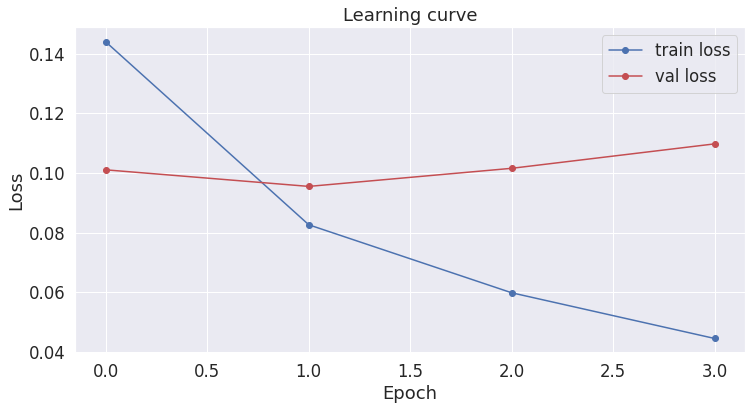

In [ ]:
# 3e5_full_5tags (epochs 0 - 3)

In [ ]:
model.load_state_dict(torch.load(model_path + "/NER3e5_full_5tags.pt"))

<All keys matched successfully>